## Feature definition and creation of NPZ files containing the feature matrix, and the target vector for each set.

In [1]:
import numpy as np
import pandas as pd
import import_ipynb
from custom_features import get_all_features
from custom_features import get_pswm  

In [2]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")

# 5-cross-validation run: for each run i, testing set=i, validation set=((i)%5)+1, training sets = remaining i sets

for i in range(1,6): #iteration on the sets 
    training_sets=((((i +1)%5)+1),(((i+2)%5)+1),(((i+3)%5)+1)) 
    testing = dataset.query(f"Set=='{i}'")
    validation = dataset.query(f"Set=='{((i)%5)+1}'")
    training = dataset.query(f"(Set=='{training_sets[0]}' or Set=='{training_sets[1]}' or Set=='{training_sets[2]}')")

    print("-"*100)
    print("testing set: ",i)
    print("validation set: ", ((i)%5)+1)
    print("training sets: ",training_sets)

    
    #TRAINING
    matrix_training = get_pswm(training , 13 , 2)
    feature_set_training , feature_order_training = get_all_features(training["Sequence"] , matrix_training, 15 )
    
    # create the target vector:
    vector_neg_pos = training["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_training_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'training_features_{i}.npz', matrix=feature_set_training, target=target_training_vector)

    #VALIDATION
    feature_set_validation , feature_order_validation = get_all_features(validation["Sequence"] , matrix_training, 15 )
 
    
    # create the target vector:
    vector_neg_pos = validation["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_validation_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'validation_features_{i}.npz', matrix=feature_set_validation, target=target_validation_vector)

    #TESTING
    feature_set_testing , feature_order_testing = get_all_features(testing["Sequence"] , matrix_training, 15 )
    
    # create the target vector:
    vector_neg_pos = testing["Class"]
    vector_proper = vector_neg_pos.map({"Positive": 1, "Negative": 0})
    target_testing_vector = vector_proper.to_numpy()
    # Save the three feature matrices and the target vector to a .npz file with different keys
    np.savez(f'testing_features_{i}.npz', matrix=feature_set_testing, target=target_testing_vector)

    #now we have created a file for each set, for that iteration

----------------------------------------------------------------------------------------------------
testing set:  1
validation set:  2
training sets:  (3, 4, 5)
----------------------------------------------------------------------------------------------------
testing set:  2
validation set:  3
training sets:  (4, 5, 1)
----------------------------------------------------------------------------------------------------
testing set:  3
validation set:  4
training sets:  (5, 1, 2)
----------------------------------------------------------------------------------------------------
testing set:  4
validation set:  5
training sets:  (1, 2, 3)
----------------------------------------------------------------------------------------------------
testing set:  5
validation set:  1
training sets:  (2, 3, 4)


## Feature selection with random forest and SVM training

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef

In [4]:
def performance_on_subset(subset_features, feature_order_training, x_train, y_train, x_val, y_val, pipeline):
    #find the col number of a specific feature
    idx = [feature_order_training.index(f) for f in subset_features]  
    #take the column of the corrispective feature
    Xtr = x_train[:, idx] 
    Xva = x_val[:, idx]
    pipeline.fit(Xtr, y_train)     # train the svm on training data
    y_pred = pipeline.predict(Xva) # predict on validation data
    mcc = matthews_corrcoef(y_val, y_pred) # compute MCC 
    return mcc  # mcc on VALIDATION

Features by Gini importance for 1-th iteration:
               feature  importance
0           VhonHeijne    0.292548
1                    C    0.062980
2      tm_tendency_max    0.036649
3   chou_fasman_h_mean    0.030787
4    max_miyazawa_mean    0.023459
5                    D    0.022553
6                    T    0.021753
7                    R    0.021033
8     chou_fasma_b_max    0.019945
9                    N    0.019910
10     flexibility_max    0.019017
11           punta_max    0.018651
12   chou_fasman_h_max    0.017990
13    tm_tendency_mean    0.017704
14      bulkiness_mean    0.017682
15                   M    0.017651
16                   L    0.017200
17    flexibility_mean    0.016184
18                   Y    0.016069
19           argos_max    0.015985
20            basicity    0.015954
21                   A    0.015948
22          punta_mean    0.015622
23                   K    0.015490
24                   Q    0.015430
25          argos_mean    0.015307
26     

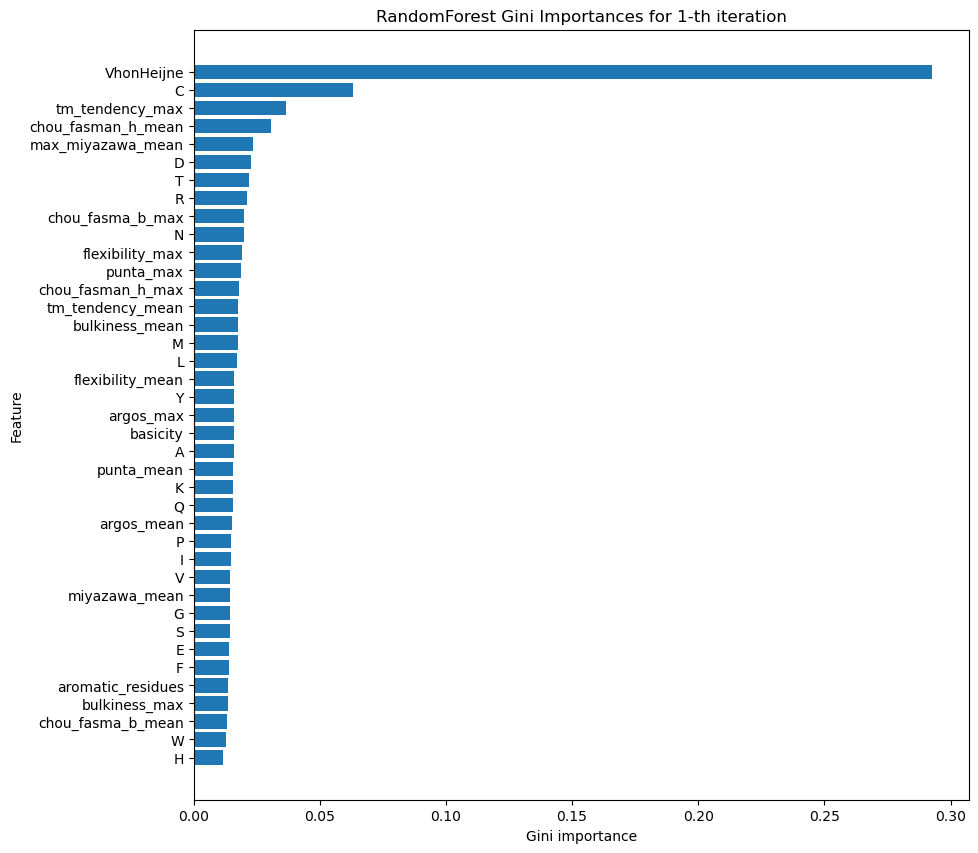

Best k on validation (using baseline best params): k=21, val_mcc=0.862


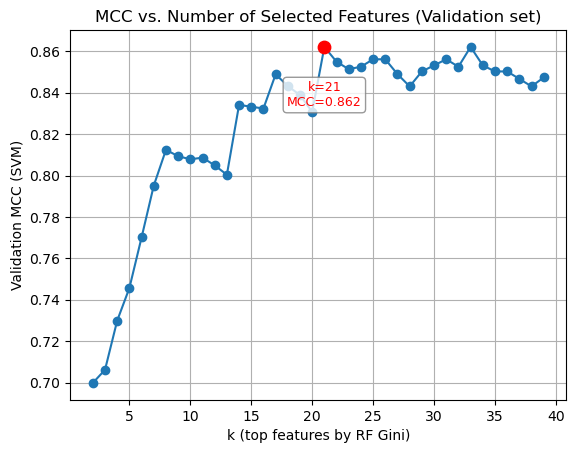

Test MCC score:  0.8065887599523724
----------------------------------------------------------------------------------------------------
Features by Gini importance for 2-th iteration:
               feature  importance
0           VhonHeijne    0.250667
1                    C    0.062331
2      tm_tendency_max    0.038570
3   chou_fasman_h_mean    0.030575
4    max_miyazawa_mean    0.027104
5                    D    0.025298
6                    R    0.023597
7     chou_fasma_b_max    0.022978
8                    T    0.022618
9                    N    0.020528
10      bulkiness_mean    0.019636
11                   P    0.019256
12                   M    0.019185
13     flexibility_max    0.019139
14           punta_max    0.018984
15                   K    0.018185
16                   G    0.017836
17                   S    0.017461
18           argos_max    0.017425
19       bulkiness_max    0.017294
20                   F    0.016896
21                   E    0.016788
22        

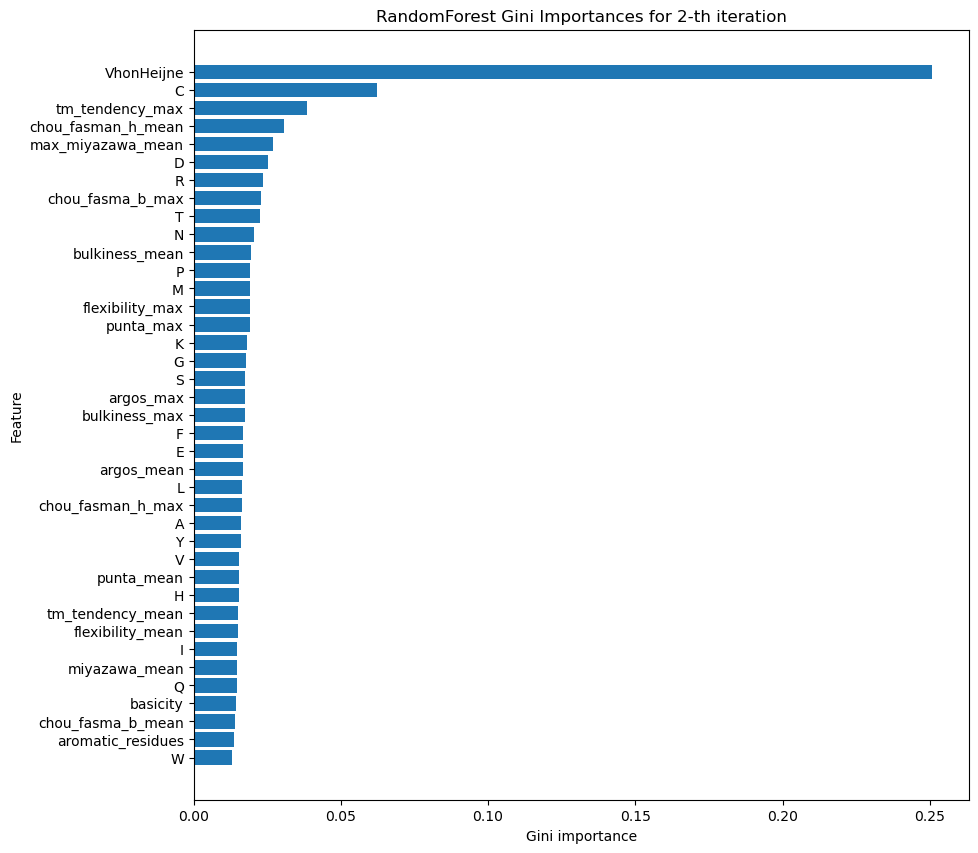

Best k on validation (using baseline best params): k=21, val_mcc=0.867


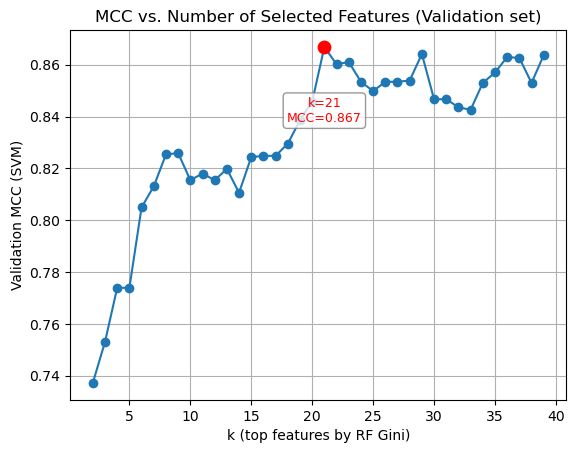

Test MCC score:  0.8197378054065826
----------------------------------------------------------------------------------------------------
Features by Gini importance for 3-th iteration:
               feature  importance
0           VhonHeijne    0.256648
1                    C    0.059985
2      tm_tendency_max    0.037293
3   chou_fasman_h_mean    0.030622
4                    T    0.027769
5    max_miyazawa_mean    0.026498
6                    R    0.023956
7                    D    0.022868
8     chou_fasma_b_max    0.022243
9                    N    0.020871
10           punta_max    0.020724
11     flexibility_max    0.020292
12                   M    0.020000
13                   P    0.019855
14      bulkiness_mean    0.018981
15           argos_max    0.018979
16                   A    0.018078
17            basicity    0.017871
18          argos_mean    0.017841
19                   L    0.017253
20                   G    0.016316
21    tm_tendency_mean    0.016011
22        

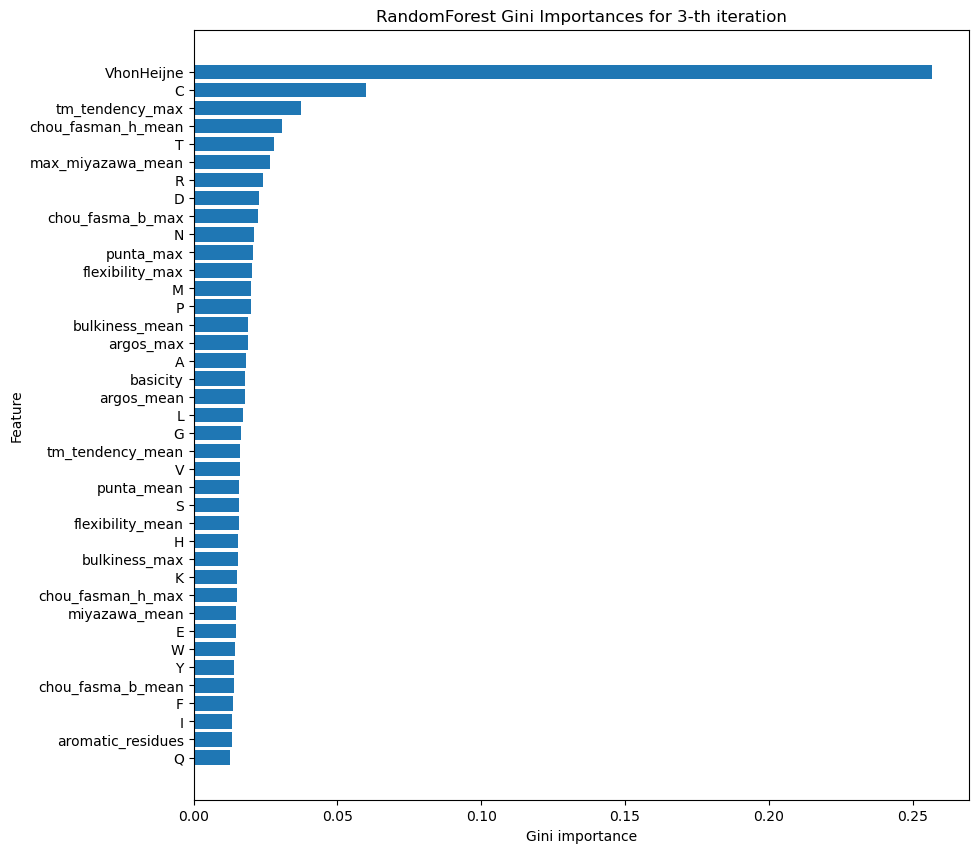

Best k on validation (using baseline best params): k=24, val_mcc=0.794


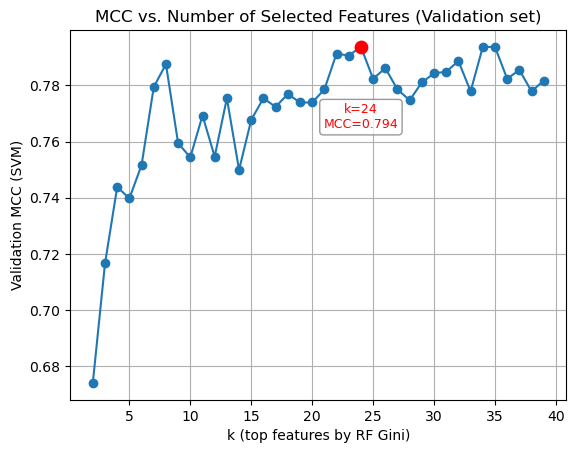

Test MCC score:  0.8519171056736888
----------------------------------------------------------------------------------------------------
Features by Gini importance for 4-th iteration:
               feature  importance
0           VhonHeijne    0.272459
1                    C    0.057936
2      tm_tendency_max    0.037670
3   chou_fasman_h_mean    0.030897
4                    T    0.025223
5    max_miyazawa_mean    0.024765
6                    R    0.024182
7                    D    0.021887
8                    M    0.021706
9       bulkiness_mean    0.020781
10           punta_max    0.020549
11                   L    0.020401
12    chou_fasma_b_max    0.019780
13            basicity    0.018882
14                   N    0.017771
15       bulkiness_max    0.017676
16          argos_mean    0.017662
17           argos_max    0.017576
18    flexibility_mean    0.017241
19       miyazawa_mean    0.016993
20     flexibility_max    0.016841
21                   V    0.016232
22        

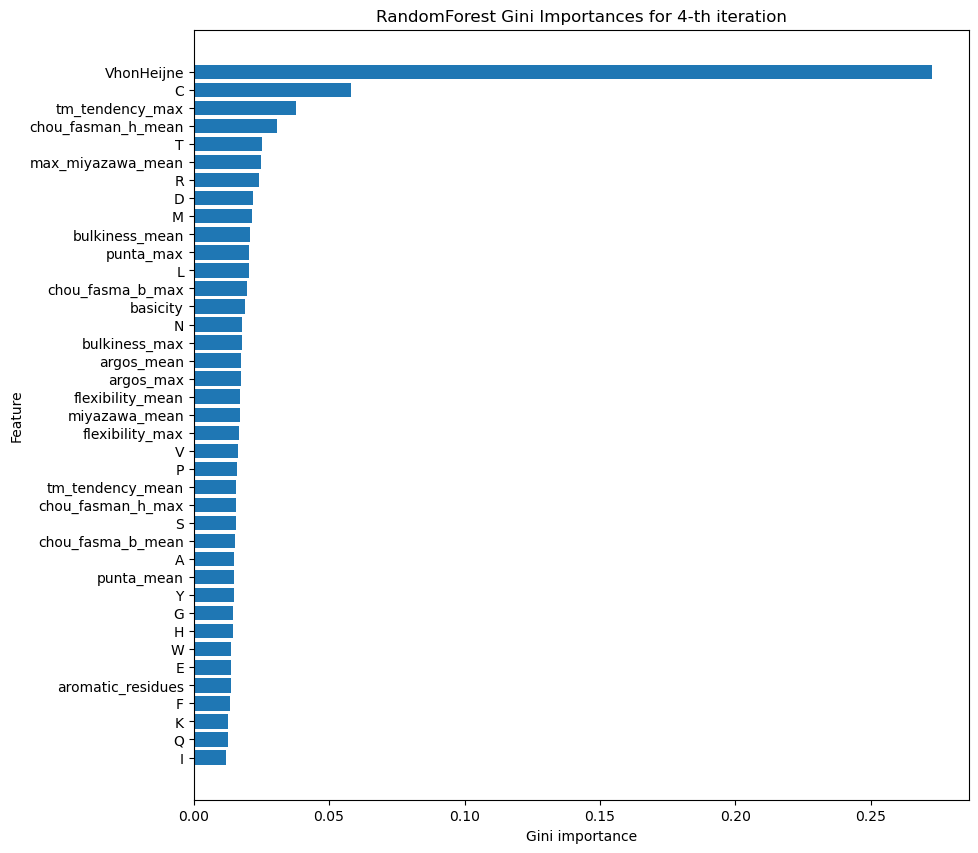

Best k on validation (using baseline best params): k=29, val_mcc=0.841


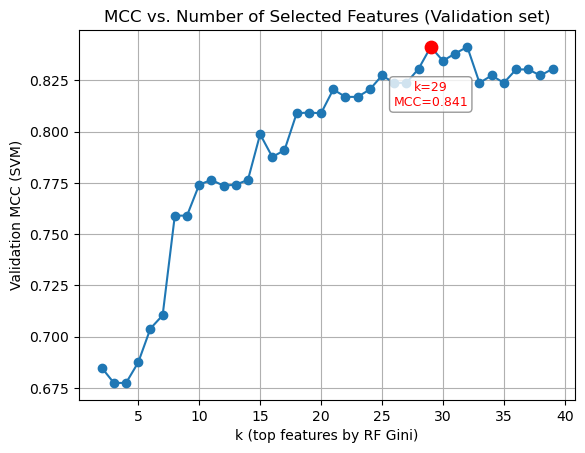

Test MCC score:  0.7886778400339554
----------------------------------------------------------------------------------------------------
Features by Gini importance for 5-th iteration:
               feature  importance
0           VhonHeijne    0.291391
1                    C    0.052211
2      tm_tendency_max    0.036229
3   chou_fasman_h_mean    0.032234
4    max_miyazawa_mean    0.024135
5                    T    0.023397
6                    R    0.022839
7                    N    0.021660
8                    L    0.021162
9                    D    0.020235
10                   M    0.019510
11            basicity    0.019030
12    chou_fasma_b_max    0.018444
13           punta_max    0.018161
14    tm_tendency_mean    0.018130
15      bulkiness_mean    0.017810
16                   G    0.017088
17           argos_max    0.016997
18          punta_mean    0.016584
19     flexibility_max    0.016318
20          argos_mean    0.015717
21                   V    0.015708
22        

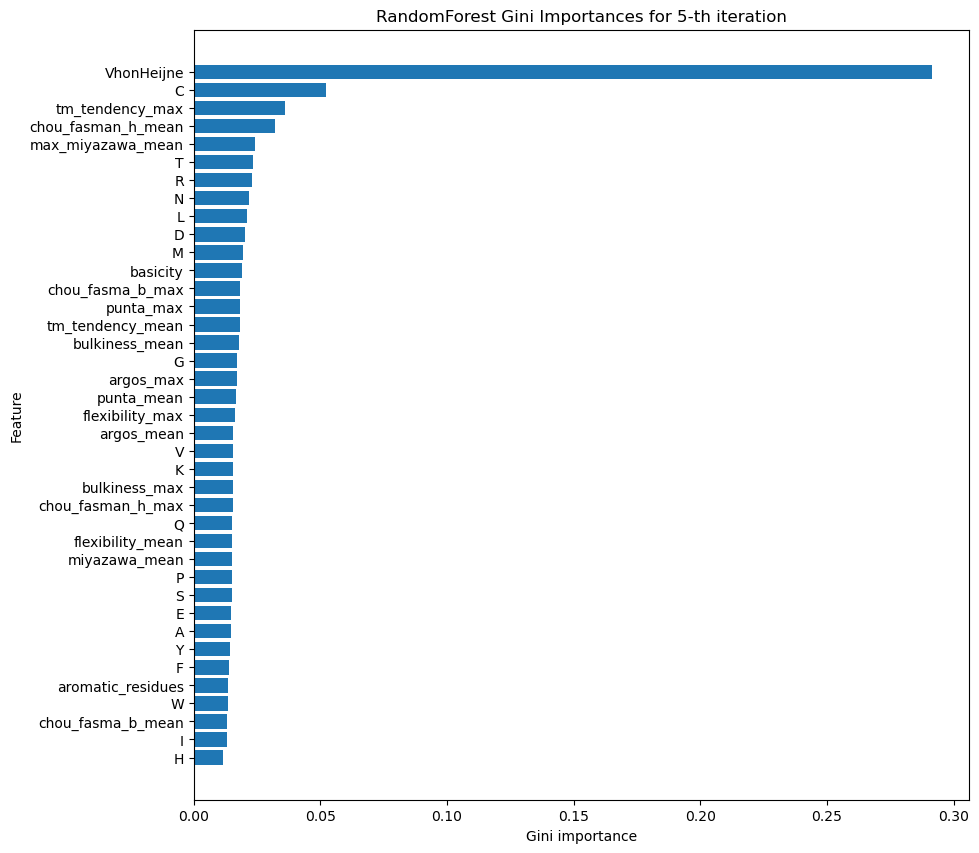

Best k on validation (using baseline best params): k=38, val_mcc=0.832


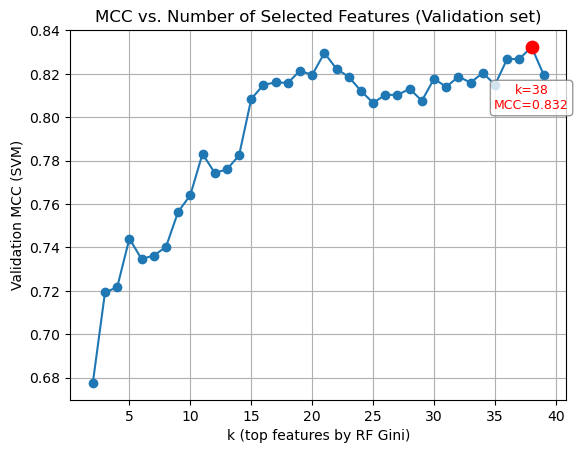

Test MCC score:  0.8341710177281045
----------------------------------------------------------------------------------------------------


In [5]:
# create a simple grid for initial SVM parameters
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

feature_counter={}
#create a Pipeline with StandardScaler to normalize data and SVC as predictor model
pipeline = Pipeline([("scaler" , StandardScaler()) , ("svm" , SVC())])
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=50, class_weight={0: 9, 1: 1}) # construct the random forest classifier 

for i in range(1,6): #iteration on the sets 
    #Load the npz files of training, testing and validation sets for each iteration
    # load training
    loaded_data_train = np.load(f'training_features_{i}.npz')
    x_train = loaded_data_train['matrix']
    y_train = loaded_data_train['target']
    
    # load test
    loaded_data_test = np.load(f'testing_features_{i}.npz')
    x_test = loaded_data_test['matrix']
    y_test = loaded_data_test['target']
    
    # load validation
    loaded_data_validation = np.load(f'validation_features_{i}.npz')
    x_validation = loaded_data_validation['matrix']
    y_validation = loaded_data_validation['target']

    #INITIALIZING OF GAMMA AND C VALUES
    # grid search to set initial C and gamma parameters
    best_mcc=-1  #initialize mcc as -1
    # iterate over C and gamma we defined earlier
    for C in C_grid: 
        for gamma in gamma_grid:
            #use the pipeline we created earlier with rbf kernel
            pipeline.set_params(svm__kernel="rbf",svm__C=C , svm__gamma=gamma)
            pipeline.fit(x_train, y_train)  # fit on training data
            y_pred = pipeline.predict(x_test) # predict on test data
            mcc = matthews_corrcoef(y_test, y_pred) # compute MCC     
            # store parameter values that give best MCC
            if mcc > best_mcc:
                best_mcc = mcc
                best_params_base =  (C, gamma)
    pipeline.set_params(svm__kernel="rbf", svm__C=best_params_base[0], svm__gamma=best_params_base[1])
    rf.fit(x_train, y_train)  # fit on train data
    # create a Series with feature name and the corresponding feature importance based on Gini impurity
    gini_imp = pd.Series(rf.feature_importances_, index=feature_order_training).sort_values(ascending=False) 
    gini_df = gini_imp.reset_index()
    # name the columns
    gini_df.columns = ["feature", "importance"]
    print(f"Features by Gini importance for {i}-th iteration:")
    print(gini_df)

    # Plot the results
    plt.figure(figsize=(10, 10))
    plt.barh(gini_df["feature"][::-1], gini_df["importance"][::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances for {i}-th iteration")
    plt.show()

    # FIND THE BEST NUMBER OF FEATURES (K)
    # create a list with all the features
    ks = list(range(2, x_train.shape[1]+1))
    curve = []
    
    #iterate over possible k-features
    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        mcc_k = performance_on_subset(subset, feature_order_training, x_train, y_train, x_validation, y_validation, pipeline)
        curve.append(mcc_k)
        
    # find the k that maximizes the MCC 
    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]

    #count how many times a feature appears in each iteration
    for feature in gini_df["feature"].head(best_k):
        feature_counter[feature] = feature_counter.get(feature, 0) + 1

    print(f"Best k on validation (using baseline best params): k={best_k}, val_mcc={curve[best_k_idx]:.3f}")
    
    #plot the MCC curve 
    plt.figure()
    plt.plot(ks, curve, marker="o")
    #highlight the best MCC 
    plt.scatter(best_k, curve[best_k_idx] , color="red", s=80, zorder=5)
    plt.text(best_k, curve[best_k_idx] - 0.03, f"k={best_k}\nMCC={curve[best_k_idx]:.3f}",
         ha="center", va="bottom", fontsize=9, color="red", bbox=dict(
        facecolor="white",   # colore di sfondo
        alpha=0.8,           # trasparenza (1=opaco)
        edgecolor="gray",    # colore del bordo
        boxstyle="round,pad=0.3"  # forma del riquadro ("round" o "square")
    ))
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation MCC (SVM)")
    plt.title("MCC vs. Number of Selected Features (Validation set)")
    plt.grid(True)
    plt.show()

    #TESTING PROCEDURE
    # Use the best k from the validation curve to perform the testing procedure
    best_subset = gini_df["feature"].head(best_k).tolist()
    idx = [feature_order_training.index(f) for f in best_subset]
    #recover the most informative features from the training set (useful for grid search) and the testing set. 
    Xtr_sel = x_train[:, idx]
    Xte_sel = x_test[:, idx]
    Xva_sel = x_validation[:, idx]
    # Manual grid search again but now restricted to the selected features
    best_score_sel = -np.inf
    best_params_sel = None
    
    # grid search iterations
    for C in C_grid:
        for gamma in gamma_grid:
            pipeline.set_params(svm__kernel="rbf",svm__C=C , svm__gamma=gamma)
            pipeline.fit(Xtr_sel, y_train)      # train on TRAIN
            val_mcc = pipeline.score(Xva_sel, y_validation)  # validate on VAL
            if val_mcc > best_score_sel:
                best_score_sel = val_mcc
                best_params_sel =(C,gamma)
    #set the SVM with the best parameters found in the grid search 
    pipeline.set_params(svm__kernel="rbf", svm__C=best_params_base[0], svm__gamma=best_params_base[1])
    #train the SVM with the restricted features
    pipeline.fit(Xtr_sel, y_train) 
    # predict on test data
    y_pred_sel = pipeline.predict(Xte_sel)
    # compute MCC
    mcc = matthews_corrcoef(y_test, y_pred_sel)
    
    print("Test MCC score: ", mcc)
    print("-"*100)

In [6]:
#Select the features that we will use for training the final model
features_to_use= [k for k, v in feature_counter.items() if v > 4]
print("Feature to use: "+ str(features_to_use)+ "\n"+"Number of features: "+ str(len(features_to_use)))


Feature to use: ['VhonHeijne', 'C', 'tm_tendency_max', 'chou_fasman_h_mean', 'max_miyazawa_mean', 'D', 'T', 'R', 'chou_fasma_b_max', 'N', 'flexibility_max', 'punta_max', 'bulkiness_mean', 'M', 'argos_max']
Number of features: 15
